In [68]:
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
from skimage import util 
from sklearn.model_selection import train_test_split
import seaborn as sns

This dataset consists of 70000 images of handwritten digits from 0 to 9 by high school students and employees of the US Census Bureau. They should be automatically recognized by a suitable algorithm. 

## Data Exploration

### Load data

In [75]:
X_train = idx2numpy.convert_from_file('samples/train-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('samples/train-labels.idx1-ubyte')

In [76]:
X_test = idx2numpy.convert_from_file('samples/t10k-images.idx3-ubyte')
y_test = idx2numpy.convert_from_file('samples/t10k-labels.idx1-ubyte')

In [77]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Check assumption of equal proportion of classes

In [84]:
np.sum(y_train==0), np.sum(y_train==1), np.sum(y_train==2), np.sum(y_train==3), np.sum(y_train==4), np.sum(y_train==5), np.sum(y_train==6), np.sum(y_train==7), np.sum(y_train==8), np.sum(y_train==9)

(5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949)

### Visualization

<Figure size 432x288 with 0 Axes>

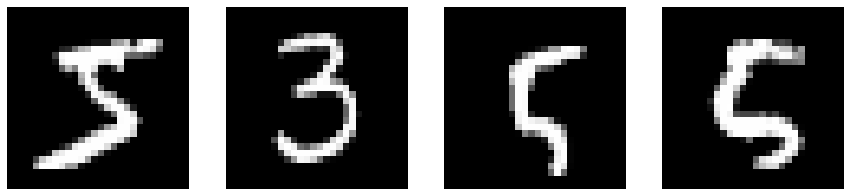

In [4]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(15,15))
ax1 = axes[0]
ax1.imshow(X_train[0], cmap='Greys_r')
ax1.axis('off')
ax2 = axes[1]
ax2.imshow(X_train[50], cmap='Greys_r')
ax2.axis('off')
ax3 = axes[2]
ax3.imshow(X_train[100], cmap='Greys_r')
ax3.axis('off')
ax4 = axes[3]
ax4.imshow(X_train[2000], cmap='Greys_r')
ax4.axis('off');

Main properties of the data:   
- 60000 images with a resolution of 28x28 in the training set, 10000 in the test set
- digits from 0 to 9
- grayscale: white digits on black background
- the observed digits are about equally distributed in the training dataset

## Data preprocessing

### Flattening

In [78]:
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### Normalization

In [7]:
X_train.min(), X_train.max()

(0, 255)

In [79]:
X_train = X_train / 255
X_test = X_test / 255

In [20]:
X_train.min(), X_train.max()

(0.0, 1.0)

## Model Training and Optimization: Random Forest

Rationale of the selection of this model class:   
- it is a simple and fast algorithm 
- through ensembling the algorithm balances out the tendency of decision trees to overfitting
- the performance of the algorithm is surprisingly good also for multiclass classification
- the results are well interpretable
- the algorithm needs nearly no data preprocessing
- it is also applicable for this dataset with respect to the assumption of equal proportion of classes

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

validation dataset

In [6]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

### Simple Decision Tree

Decision Tree is chosen as first model class to compare the resulting performance with the random forest algorithm

Get ccp_alphas for Pruning

In [8]:
clf = DecisionTreeClassifier(random_state=0)

In [9]:
path = clf.cost_complexity_pruning_path(X_train_val, y_train_val)
ccp_alphas_all = path.ccp_alphas[:-1]

In [10]:
ccp_alphas = np.linspace(0.0, ccp_alphas_all[-1], 10)
ccp_alphas

array([0.        , 0.00428215, 0.00856429, 0.01284644, 0.01712859,
       0.02141074, 0.02569288, 0.02997503, 0.03425718, 0.03853933])

define hyperparameter ranges for gridsearch

In [11]:
param_grid_dt = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : np.logspace(3, 5, base=2, num=6),
    'criterion' :['gini', 'entropy'],
    'ccp_alpha' : ccp_alphas
}

In [12]:
model_dt_val = GridSearchCV(
            clf,
            param_grid_dt,
            cv=5,
            n_jobs=4
            )

train model

In [13]:
model_dt_val.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='depre...
             param_grid={'ccp_alpha': array([0.        , 0.00428215, 0.00856429, 0.01284644, 0.01712859,
       0.02141074, 0.02569288, 0.029975

In [14]:
model_dt_val.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 24.251465064166364,
 'max_features': 'sqrt'}

seemingly there is no necessity for pruning (best value for ccp_alpha: 0.0)

In [15]:
y_pred_dt_val = model_dt_val.predict(X_test_val)

In [18]:
accuracy_score(y_pred_dt_val, y_test_val)

0.831

In [19]:
model_dt = DecisionTreeClassifier(max_depth=24.25, criterion='entropy', max_features='sqrt')

In [20]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=24.25, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

Evaluation

In [49]:
y_pred_dt = model_dt.predict(X_test)
y_pred_dt_train = model_dt.predict(X_train)
print('Training-accuracy:', accuracy_score(y_pred_dt_train, y_train))
print('Test-accuracy:', accuracy_score(y_pred_dt, y_test))

Training-accuracy: 1.0
Test-accuracy: 0.848


The algorithm is clearly overfitting here. Training performance at 1.0 lies way over test performance. Thus the generalization of the model is weak.

### Random Forest

define hyperparameter ranges for gridsearch

In [35]:
param_grid = { 
    'n_estimators': [500, 750],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : np.logspace(5, 6, base=2, num=6),
    'criterion' :['gini', 'entropy']
}

In [36]:
model_rf_val = GridSearchCV(
            RandomForestClassifier(),
            param_grid,
            cv=5,
            n_jobs=4)

train model

In [37]:
model_rf_val.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [38]:
model_rf_val.best_params_

{'criterion': 'gini',
 'max_depth': 42.22425314473263,
 'max_features': 'sqrt',
 'n_estimators': 750}

In [50]:
y_pred_val = model_rf_val.predict(X_test_val)

In [53]:
accuracy_score(y_pred_val, y_test_val)

0.97025

In [43]:
model_rf = RandomForestClassifier(n_estimators=750, criterion='gini', max_depth=43, max_features='sqrt')

In [44]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=43, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=750,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Model Evaluation: Random Forest

In [55]:
y_pred_rf = model_rf.predict(X_test)
y_pred_rf_train = model_rf.predict(X_train)
print('Training-accuracy: ', accuracy_score(y_pred_rf_train, y_train))
print('Test-accuracy: ', accuracy_score(y_pred_rf, y_test))

Training-accuracy:  1.0
Test-accuracy:  0.9717


still overfitting, but through ensembling and majority voting clearly better test performance and thus improved generalization of the model

### Exploring the classification performance with the confusion matrix

In [67]:
cm = confusion_matrix(y_pred_rf, y_test, normalize='true')

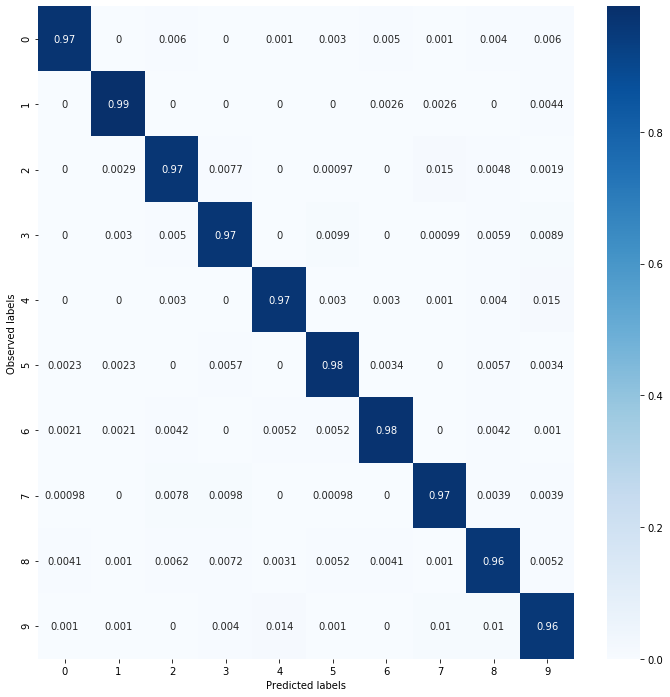

In [73]:
fig = plt.figure(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Observed labels')
ax.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]);
ax.yaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]);
plt.show();

- The algorithm shows highest performance with digit '1' (0.99)
- Slightly weaker performance is apparent with digits '8' and '9' (0.96 respectively)
- Observed digit '8' most often confused with '3', and observed digit '9' is most often confused with digit '4'
- False prediction of '8' is mostly observed with digit '9', false prediction of '9' is most often observed with digit '4'